<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Description of Stacking in Machine Learning

**Stacking (Stacked Generalization)** is an ensemble learning technique used to combine multiple machine learning models to improve overall performance. The fundamental idea behind stacking is to leverage the strengths of different models by combining their predictions to make more accurate and robust predictions.

#### What is Stacking?

1. **Base Models (Level-0 Models)**:
   - These are the individual models that are trained on the same dataset. Each base model may learn different aspects of the data, potentially making different types of errors.
   - Common base models include logistic regression, decision trees, random forests, support vector machines, and gradient boosting machines.

2. **Meta-Model (Level-1 Model)**:
   - The meta-model is trained to combine the predictions of the base models. It takes the outputs (predictions) of the base models as input features.
   - The meta-model learns to predict the final output based on the patterns and correlations it finds in the predictions of the base models.

3. **Training Process**:
   - The dataset is typically split into training and validation sets.
   - Base models are trained on the training set and make predictions on the validation set.
   - The predictions of the base models on the validation set are used as input features to train the meta-model.
   - In the final prediction phase, the base models make predictions on new data, and these predictions are fed into the meta-model to make the final prediction.

#### Why Use Stacking?

1. **Improved Performance**:
   - By combining the strengths of multiple models, stacking often results in better predictive performance than any single model alone.
   - Different models may capture different aspects of the data, and the meta-model can learn to weigh these appropriately.

2. **Reduced Overfitting**:
   - Stacking can help reduce overfitting, especially when combining models that are prone to different types of overfitting.
   - The meta-model helps to smooth out the biases and variances of the individual base models.

3. **Flexibility**:
   - Stacking allows the use of a wide variety of base models, including both linear and non-linear models.
   - It can be easily extended to include more complex meta-models, such as neural networks.

#### How Stacking Relates to Machine Learning

1. **Ensemble Learning**:
   - Stacking is a type of ensemble learning, which aims to improve the robustness and accuracy of predictions by combining multiple models.
   - Other common ensemble methods include bagging (e.g., Random Forests) and boosting (e.g., AdaBoost, XGBoost).

2. **Combining Strengths**:
   - Different machine learning algorithms have different strengths and weaknesses. Stacking leverages the strengths of multiple algorithms, leading to more accurate and reliable predictions.

3. **Practical Application**:
   - Stacking is widely used in competitive machine learning, such as in Kaggle competitions, where the goal is to achieve the highest possible predictive performance.
   - It is also used in real-world applications where robustness and accuracy are critical.

### Summary

In this experiment, we are:

1. **Evaluating Multiple Models**: Assessing the performance of different models (Logistic Regression, Random Forest, SVM, XGBoost) to identify the best performing model.
2. **Implementing Stacking**: Combining the strengths of multiple models using stacking to improve overall performance.
3. **Comparing Results**: Comparing the performance metrics of individual models and the stacked model to determine the optimal approach for predicting loan defaults.

Stacking helps to create a robust model by leveraging the strengths of multiple models, potentially leading to better overall performance in terms of recall, precision, and F1 scores.

### Baseline Model

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, f1_score
from loan_data_utils import load_and_preprocess_data

# Parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the logistic regression model with class weights
baseline_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

# Create the baseline pipeline
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', baseline_model)
])

# Fit the baseline pipeline to the training data
baseline_pipeline.fit(X_train, y_train)

# Predict probabilities for the test data
optimal_threshold = 0.25
baseline_y_proba = baseline_pipeline.predict_proba(X_test)[:, 1]
baseline_y_pred = (baseline_y_proba >= optimal_threshold).astype(int)

# Evaluate the baseline model
baseline_recall_class1 = recall_score(y_test, baseline_y_pred, pos_label=1)
baseline_f1_balanced = f1_score(y_test, baseline_y_pred, average='binary', pos_label=1)
baseline_f1_macro = f1_score(y_test, baseline_y_pred, average='macro')

print("Baseline Model Performance with Optimal Threshold:")
print(f"Recall Class 1: {baseline_recall_class1:.4f}")
print(f"F1 Score (balanced): {baseline_f1_balanced:.4f}")
print(f"F1 Score (macro): {baseline_f1_macro:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, baseline_y_pred))

# Save the baseline results
baseline_results = {
    'Method': 'Baseline',
    'Recall Class 1': baseline_recall_class1,
    'F1 Score (balanced)': baseline_f1_balanced,
    'F1 Score (macro)': baseline_f1_macro,
    'Threshold': 'Optimal (0.25)'
}


Baseline Model Performance with Optimal Threshold:
Recall Class 1: 0.9254
F1 Score (balanced): 0.3795
F1 Score (macro): 0.3265

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4673
           1       0.24      0.93      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.56      0.54      0.33      6000
weighted avg       0.74      0.33      0.30      6000



### Train Base Models



In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
from loan_data_utils import load_and_preprocess_data
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

# Parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# High Recall Model
high_recall_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
high_recall_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', high_recall_model)
])
high_recall_pipeline.fit(X_train, y_train)
high_recall_proba = high_recall_pipeline.predict_proba(X_test)[:, 1]
high_recall_pred = (high_recall_proba >= 0.25).astype(int)

# High Precision Model
high_precision_model = RandomForestClassifier(random_state=42)
high_precision_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', high_precision_model)
])
high_precision_pipeline.fit(X_train, y_train)
high_precision_proba = high_precision_pipeline.predict_proba(X_test)[:, 1]
high_precision_pred = (high_precision_proba >= 0.5).astype(int)  # Default threshold for precision

# Evaluate Base Models
print("High Recall Model Performance:")
print(f"Recall: {recall_score(y_test, high_recall_pred, pos_label=1):.4f}")
print(f"Precision: {precision_score(y_test, high_recall_pred, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, high_recall_pred, pos_label=1):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, high_recall_pred))

print("\nHigh Precision Model Performance:")
print(f"Recall: {recall_score(y_test, high_precision_pred, pos_label=1):.4f}")
print(f"Precision: {precision_score(y_test, high_precision_pred, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, high_precision_pred, pos_label=1):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, high_precision_pred))


High Recall Model Performance:
Recall: 0.9254
Precision: 0.2387
F1 Score: 0.3795

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4673
           1       0.24      0.93      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.56      0.54      0.33      6000
weighted avg       0.74      0.33      0.30      6000


High Precision Model Performance:
Recall: 0.3730
Precision: 0.6282
F1 Score: 0.4681

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.63      0.37      0.47      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.66      0.68      6000
weighted avg       0.79      0.81      0.79      6000



In [3]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
# from loan_data_utils import load_and_preprocess_data
# import logging

# # Set up logging
# logging.basicConfig(level=logging.INFO)

# # Parameters
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
# categorical_columns = ['sex', 'education', 'marriage']
# target = 'default_payment_next_month'

# # Load and preprocess data
# X, y = load_and_preprocess_data(url, categorical_columns, target)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Identify numeric and categorical columns
# numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# # Define the column transformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='median')),
#             ('scaler', StandardScaler())
#         ]), numeric_features),
#         ('cat', Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='most_frequent')),
#             ('encoder', OneHotEncoder(drop='first'))
#         ]), categorical_features)
#     ])

# # High Recall Model
# high_recall_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
# high_recall_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', high_recall_model)
# ])
# high_recall_pipeline.fit(X_train, y_train)
# high_recall_proba = high_recall_pipeline.predict_proba(X_test)[:, 1]
# high_recall_pred = (high_recall_proba >= 0.25).astype(int)

# # High Precision Model
# high_precision_model = RandomForestClassifier(random_state=42, class_weight='balanced')
# high_precision_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', high_precision_model)
# ])
# high_precision_pipeline.fit(X_train, y_train)
# high_precision_proba = high_precision_pipeline.predict_proba(X_test)[:, 1]
# high_precision_pred = (high_precision_proba >= 0.5).astype(int)  # Default threshold for precision

# # Evaluate Base Models
# print("High Recall Model Performance:")
# print(f"Recall: {recall_score(y_test, high_recall_pred, pos_label=1):.4f}")
# print(f"Precision: {precision_score(y_test, high_recall_pred, pos_label=1):.4f}")
# print(f"F1 Score: {f1_score(y_test, high_recall_pred, pos_label=1):.4f}")
# print("\nClassification Report:")
# print(classification_report(y_test, high_recall_pred))

# print("\nHigh Precision Model Performance:")
# print(f"Recall: {recall_score(y_test, high_precision_pred, pos_label=1):.4f}")
# print(f"Precision: {precision_score(y_test, high_precision_pred, pos_label=1):.4f}")
# print(f"F1 Score: {f1_score(y_test, high_precision_pred, pos_label=1):.4f}")
# print("\nClassification Report:")
# print(classification_report(y_test, high_precision_pred))


High Recall Model Performance:
Recall: 0.9254
Precision: 0.2387
F1 Score: 0.3795

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4673
           1       0.24      0.93      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.56      0.54      0.33      6000
weighted avg       0.74      0.33      0.30      6000


High Precision Model Performance:
Recall: 0.3504
Precision: 0.6414
F1 Score: 0.4532

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.64      0.35      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



### Train a Meta-Model

In [18]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Create new training data from base model predictions
train_meta_features = np.column_stack([
    high_recall_pipeline.predict_proba(X_train)[:, 1],
    high_precision_pipeline.predict_proba(X_train)[:, 1]
])

test_meta_features = np.column_stack([
    high_recall_proba,
    high_precision_proba
])

# Train the meta-model
meta_model = LogisticRegression(random_state=42)
meta_model.fit(train_meta_features, y_train)

# Predict with the meta-model
meta_proba = meta_model.predict_proba(test_meta_features)[:, 1]
meta_pred = (meta_proba >= 0.25).astype(int)

# Evaluate the meta-model
print("Meta-Model Performance:")
print(f"Recall: {recall_score(y_test, meta_pred, pos_label=1):.4f}")
print(f"Precision: {precision_score(y_test, meta_pred, pos_label=1):.4f}")
print(f"F1 Score: {f1_score(y_test, meta_pred, pos_label=1):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, meta_pred))

Meta-Model Performance:
Recall: 0.4529
Precision: 0.5606
F1 Score: 0.5010

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      4673
           1       0.56      0.45      0.50      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.68      0.69      6000
weighted avg       0.79      0.80      0.79      6000



In [4]:
# import numpy as np
# from sklearn.linear_model import LogisticRegression

# # Create new training data from base model predictions
# train_meta_features = np.column_stack([
#     high_recall_pipeline.predict_proba(X_train)[:, 1],
#     high_precision_pipeline.predict_proba(X_train)[:, 1]
# ])

# test_meta_features = np.column_stack([
#     high_recall_proba,
#     high_precision_proba
# ])

# # Train the meta-model
# meta_model = LogisticRegression(random_state=42)
# meta_model.fit(train_meta_features, y_train)

# # Predict with the meta-model
# meta_proba = meta_model.predict_proba(test_meta_features)[:, 1]
# meta_pred = (meta_proba >= 0.25).astype(int)

# # Evaluate the meta-model
# print("Meta-Model Performance:")
# print(f"Recall: {recall_score(y_test, meta_pred, pos_label=1):.4f}")
# print(f"Precision: {precision_score(y_test, meta_pred, pos_label=1):.4f}")
# print(f"F1 Score: {f1_score(y_test, meta_pred, pos_label=1):.4f}")
# print("\nClassification Report:")
# print(classification_report(y_test, meta_pred))


Meta-Model Performance:
Recall: 0.4348
Precision: 0.5876
F1 Score: 0.4998

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4673
           1       0.59      0.43      0.50      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.67      0.69      6000
weighted avg       0.79      0.81      0.80      6000



###Compare Results

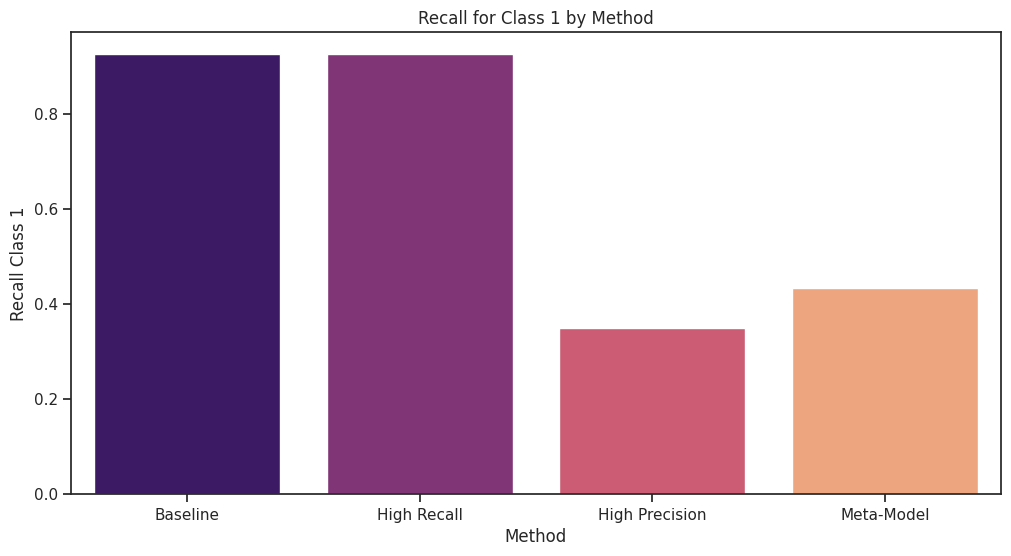

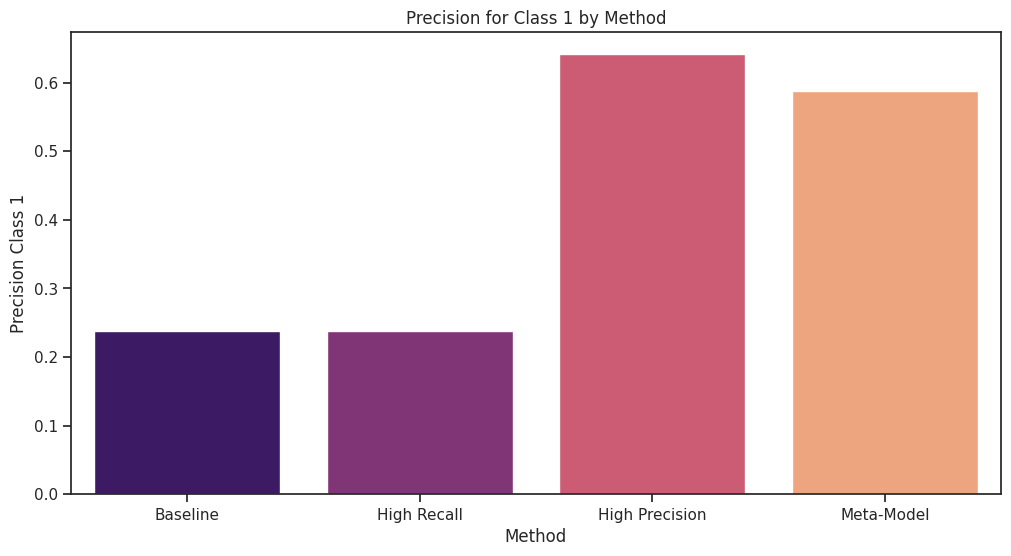

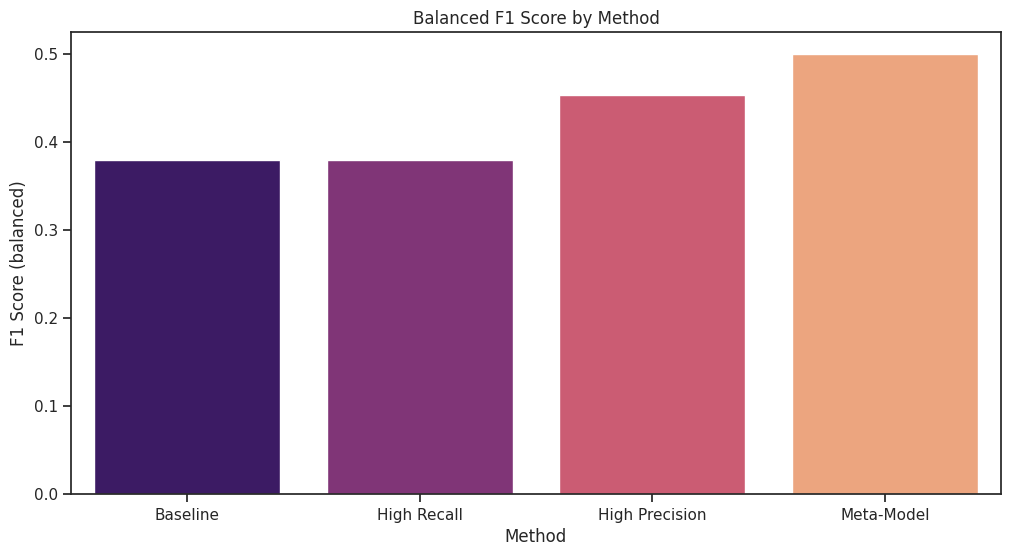

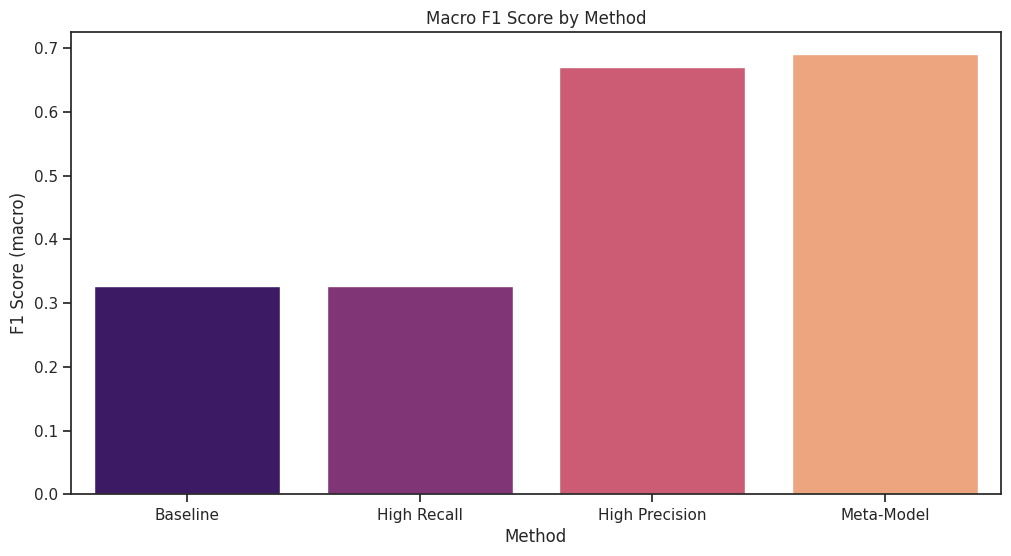

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score

# Define the function to calculate metrics
def calculate_metrics(y_true, y_pred, method_name):
    recall = recall_score(y_true, y_pred, pos_label=1)
    precision = precision_score(y_true, y_pred, pos_label=1)
    f1_balanced = f1_score(y_true, y_pred, pos_label=1)
    f1_macro = f1_score(y_true, y_pred, average='macro')

    return {
        'Method': method_name,
        'Recall Class 1': recall,
        'Precision Class 1': precision,
        'F1 Score (balanced)': f1_balanced,
        'F1 Score (macro)': f1_macro
    }

# Calculate metrics for each model
baseline_metrics = calculate_metrics(y_test, baseline_y_pred, 'Baseline')
high_recall_metrics = calculate_metrics(y_test, high_recall_pred, 'High Recall')
high_precision_metrics = calculate_metrics(y_test, high_precision_pred, 'High Precision')
meta_metrics = calculate_metrics(y_test, meta_pred, 'Meta-Model')

# Combine results into a DataFrame
results_df = pd.DataFrame([baseline_metrics, high_recall_metrics, high_precision_metrics, meta_metrics])

# Function to plot the performance metrics for combined results
def plot_combined_metrics(results_df, metric, title, ylabel):
    sns.set_context('notebook')
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Method', y=metric, data=results_df, hue='Method', palette='magma', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Method')
    ax.set_ylabel(ylabel)

    plt.show()

# Metrics to plot
metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Method', 'Recall Class 1'),
    ('Precision Class 1', 'Precision for Class 1 by Method', 'Precision Class 1'),
    ('F1 Score (balanced)', 'Balanced F1 Score by Method', 'F1 Score (balanced)'),
    ('F1 Score (macro)', 'Macro F1 Score by Method', 'F1 Score (macro)')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_combined_metrics(results_df, metric, title, ylabel)


In [15]:
# Display the combined results
print("Combined Performance Metrics:")
results_df

Combined Performance Metrics:


,Method,Recall Class 1,Precision Class 1,F1 Score (balanced),F1 Score (macro)
0,Baseline,0.925396,0.238678,0.379481,0.326499
1,High Recall,0.925396,0.238678,0.379481,0.326499
2,High Precision,0.350414,0.641379,0.453216,0.670215
3,Meta-Model,0.434815,0.587576,0.499783,0.690300


Given that the results for both resampling inside and outside the pipeline are almost identical to the baseline model, it seems that the resampling is not having the intended effect on improving recall or other metrics. Here are some recommendations to address this:

1. **Verify Resampling**: Ensure that the resampling is applied correctly. Since the class distribution was confirmed to be 50/50 after resampling, this step is likely correct.

2. **Explore Different Resampling Methods**: Random oversampling might not be the most effective method for your dataset. Consider using other techniques like SMOTE (Synthetic Minority Over-sampling Technique) or ADASYN (Adaptive Synthetic Sampling).

3. **Adjust Model Parameters**: Tuning the hyperparameters of your logistic regression model could help. Using techniques like grid search or randomized search for hyperparameter tuning might improve performance.

4. **Feature Engineering**: Investigate creating new features or transforming existing ones. Sometimes, improving feature quality can significantly enhance model performance.

5. **Use Different Models**: Logistic regression might not be the best model for your data. Consider using more complex models like Random Forests, Gradient Boosting, or XGBoost, which might perform better.

### Summary

1. **Try Different Resampling Methods**: Use SMOTE or ADASYN instead of random oversampling.
2. **Hyperparameter Tuning**: Use grid search to find the best hyperparameters for the logistic regression model.
3. **Combine and Compare Results**: Evaluate and compare the performance of different approaches.

These steps should help in identifying a more effective strategy for improving model performance, especially for recall in class 1.

### Write Loan Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py
